# ASSIGNMENT 4

In [1]:
import pandas as pd
import numpy as np

import re
import matplotlib.pyplot as plt
import seaborn as sns
import locale

import nltk as nltk
import nltk.corpus  
from nltk.text import Text

import ipywidgets as widgets
from IPython.display import display_html
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import Pipeline

import wordcloud

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from pandarallel import pandarallel
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

Available CPUs: 8
INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Read and Process data

In [2]:
df = pd.read_csv('Food_Inspections.csv')    # Read the dataset downloaded from https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5
violations = df.dropna()   # Cleaning the data by removing null values

violations['Reasons'] = violations['Violations'].apply(lambda x: re.split('\|\s', x))   # splitting the Violations by '|' and space 

reasons = violations[['Inspection ID', 'DBA Name', 'License #', 'Address', 'Reasons', 'Inspection Date', 'Results']].explode('Reasons') #Exploding the list of violations to a separate row
reasons = pd.DataFrame(reasons)
reasons['Code'] = reasons['Reasons'].apply(lambda x: re.findall(r'^[\d]+', x))
reasons['Code'] = reasons['Code'].apply(lambda x: ''.join(map(str, x))).astype(int)

reasons['Comments'] = reasons['Reasons'].apply(lambda x: re.findall(r'\d+\.\s*.*\s*-\s*Comments\:\s*(.*)', x, re.IGNORECASE))
reasons['Reasons_modified'] = reasons['Reasons'].apply(lambda x: re.findall(r'\d+\.\s*(.*?)(?=\s*(?:-*\s*Comments*))', x, re.IGNORECASE) if (re.findall(r'(Comments)', x, re.IGNORECASE)) else re.findall(r'\d+\.\s*(.*)$', x, re.IGNORECASE))

reasons['Reasons_modified'] = reasons['Reasons_modified'].apply(lambda x: x[0].rstrip())    # rstrip() to remove spaces at the end
reasons['Comments'] = reasons['Comments'].apply(lambda x: str(np.nan) if x == [] else x[0].rstrip())

reasons[['Reasons', 'Code', 'Reasons_modified', 'Comments']].head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_24056\3404065032.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  violations['Reasons'] = violations['Violations'].apply(lambda x: re.split('\|\s', x))   # splitting the Violations by '|' and space


,Reasons,Code,Reasons_modified,Comments
36,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",3,"MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPL...",2-102.14(O) OBSERVED NO EMPLOYEE HEALTH POLICY...
36,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,5,PROCEDURES FOR RESPONDING TO VOMITING AND DIAR...,2-501.11 OBSERVED NO WRITTEN PROCEDURE NOR ADE...
36,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,10,ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED A...,6-301.14 OBSERVED HAND WASHING SIGNS ARE NEEDE...
36,21. PROPER HOT HOLDING TEMPERATURES - Comments...,21,PROPER HOT HOLDING TEMPERATURES,3-501.16(A:1) OBSERVED TIME/TEMPERATURE CONTRO...
36,33. PROPER COOLING METHODS USED; ADEQUATE EQUI...,33,PROPER COOLING METHODS USED; ADEQUATE EQUIPMEN...,4-301.11 OBSERVED A HOT HOLDING UNIT (WITH TCS...


In [3]:
reasons = reasons[reasons['Comments'] != str(np.nan)]
comments_df = (reasons.groupby(['Inspection ID', 'Results'])
      .agg({'Comments': lambda x: ", ".join(x)})
      .reset_index())
data = comments_df[(comments_df['Results'] == 'Pass') | (comments_df['Results'] == 'Fail')]
data['Label'] = data['Results'].apply(lambda x: 1 if x == 'Pass' else 0)
data.head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_24056\2795445555.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Label'] = data['Results'].apply(lambda x: 1 if x == 'Pass' else 0)


,Inspection ID,Results,Comments,Label
0,44247,Pass,All food not stored in the original container ...,1
1,44248,Pass,All food and non-food contact equipment and ut...,1
2,44249,Pass,The walls and ceilings shall be in good repair...,1
3,44250,Pass,All food and non-food contact surfaces of equi...,1
4,44251,Pass,All food and non-food contact surfaces of equi...,1


## 2. Clean and Tokenize Comments

In [4]:
stopwords = set(nltk.corpus.stopwords.words('english'))
lemmatizer = nltk.WordNetLemmatizer()

def clean_text_wo_stop_words(text):
    text = [x.lower() for x in text] # Convert to lower case

    words = [word for word in text if len(word) > 1] # Remove punctuation
    words = [word for word in words if not word.isnumeric()]
    words = [word for word in words if word.isalpha()]
    words = [word for word in words if word not in stopwords]
    words = [lemmatizer.lemmatize(x) for x in words]
    words = ' '.join(words)

    return words

In [5]:
data['Tokens_comments'] = data['Comments'].apply(lambda x: nltk.tokenize.word_tokenize(x))
data['Tokens_comments'] = data['Tokens_comments'].apply(lambda x: clean_text_wo_stop_words(x))
data.head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_24056\2077105122.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Tokens_comments'] = data['Comments'].apply(lambda x: nltk.tokenize.word_tokenize(x))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_24056\2077105122.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Tokens_comments'] = data['Tokens_comments'].apply(lambda x: clean_text_wo_stop_words(x))


,Inspection ID,Results,Comments,Label,Tokens_comments
0,44247,Pass,All food not stored in the original container ...,1,food stored original container shall stored pr...
1,44248,Pass,All food and non-food contact equipment and ut...,1,food contact equipment utensil shall smooth ea...
2,44249,Pass,The walls and ceilings shall be in good repair...,1,wall ceiling shall good repair easily cleaned ...
3,44250,Pass,All food and non-food contact surfaces of equi...,1,food contact surface equipment food storage ut...
4,44251,Pass,All food and non-food contact surfaces of equi...,1,food contact surface equipment food storage ut...


## 3. Apply text classifier and model

### 3.1 CountVectorizer

#### 3.1.1 Naive Bayes

In [6]:
X = data['Tokens_comments']
y = data['Label']
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(f"Training records, X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"Testing records, X_test: {X_test.shape} y_test: {y_test.shape}")

Training records, X_train: (106752,) y_train: (106752,)
Testing records, X_test: (35584,) y_test: (35584,)


In [7]:
vect = CountVectorizer()

In [8]:
%time
# instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()
nb.fit(vect.fit_transform(X_train), y_train)
y_pred_nb = nb.predict(vect.transform(X_test))
# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_nb) * 100:.1f}%")

Wall time: 0 ns
Test Accuracy: 91.1%


In [9]:
# calculate precision and recall
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86     11128
           1       0.96      0.91      0.93     24456

    accuracy                           0.91     35584
   macro avg       0.89      0.91      0.90     35584
weighted avg       0.92      0.91      0.91     35584



In [10]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_nb))

[[10111  1017]
 [ 2149 22307]]


Finding the best parameters for CountVectorizer

In [11]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])
parameters = {
    'vectorizer__ngram_range': [(1, 2), (1, 3)]
}
# perform grid search to find the best hyperparameters
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# train a text classifier using the best hyperparameters
best_classifier_nb = grid_search.best_estimator_
best_classifier_nb.fit(X_train, y_train)

predictions_nb = best_classifier_nb.predict(X_test)
print(f"Test Accuracy: {metrics.accuracy_score(y_test, predictions_nb) * 100:.1f}%")

Test Accuracy: 92.6%


In [12]:
grid_search.best_estimator_, grid_search.best_params_

(Pipeline(steps=[('vectorizer', CountVectorizer(ngram_range=(1, 2))),
                 ('classifier', MultinomialNB())]),
 {'vectorizer__ngram_range': (1, 2)})

In [13]:
print(classification_report(y_test, predictions_nb))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89     11128
           1       0.97      0.92      0.94     24456

    accuracy                           0.93     35584
   macro avg       0.91      0.93      0.92     35584
weighted avg       0.93      0.93      0.93     35584



In [14]:
print(confusion_matrix(y_test, predictions_nb))

[[10352   776]
 [ 1855 22601]]


#### 3.1.2 Logistic Regression

In [15]:
%time
# instantiate a logistic regression model
logreg = LogisticRegression(max_iter=2000)
logreg.fit(vect.fit_transform(X_train), y_train)
y_pred_l = logreg.predict(vect.transform(X_test))
# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_l) * 100:.1f}%")

Wall time: 0 ns
Test Accuracy: 97.7%


In [16]:
# calculate precision and recall
print(classification_report(y_test, y_pred_l))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     11128
           1       0.98      0.99      0.98     24456

    accuracy                           0.98     35584
   macro avg       0.98      0.97      0.97     35584
weighted avg       0.98      0.98      0.98     35584



In [17]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_l))

[[10521   607]
 [  220 24236]]


Finding the best parameters for CountVectorizer + Logistic Regression

In [18]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression(max_iter=5000))
])
parameters = {
    'vect__ngram_range': [(1, 2), (1, 3)],
    'clf__C': [0.01, 0.1, 1.0],
}
# perform grid search to find the best hyperparameters
grid_search = GridSearchCV(pipeline, parameters, cv=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# train a text classifier using the best hyperparameters
best_classifier_l = grid_search.best_estimator_
best_classifier_l.fit(X_train, y_train)

predictions_l = best_classifier_l.predict(X_test)
print(f"Test Accuracy: {metrics.accuracy_score(y_test, predictions_l) * 100:.1f}%")

Test Accuracy: 98.0%


In [19]:
grid_search.best_estimator_, grid_search.best_params_

(Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 3))),
                 ('clf', LogisticRegression(max_iter=5000))]),
 {'clf__C': 1.0, 'vect__ngram_range': (1, 3)})

In [20]:
print(classification_report(y_test, predictions_l))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97     11128
           1       0.98      0.99      0.99     24456

    accuracy                           0.98     35584
   macro avg       0.98      0.97      0.98     35584
weighted avg       0.98      0.98      0.98     35584



In [21]:
print(confusion_matrix(y_test, predictions_l))

[[10581   547]
 [  177 24279]]


Since Logistic Regression has better accuracy, going ahead at investigating its results

#### 3.1.3 Most Important Features

In [22]:
clf = logreg


feature_names = vect.get_feature_names_out()
coefs_with_fns = zip(feature_names, clf.coef_[0])

coefs_with_fns_df = pd.DataFrame(coefs_with_fns,
                    columns=['feature', 'coefficient'])

In [23]:
coefs_with_fns_df.sort_values(by='coefficient', ascending=True, inplace=True)
coefs_with_fns_df.head(10)

,feature,coefficient
18350,serious,-6.650053
5186,critical,-4.947235
15677,priority,-3.720797
12036,logbook,-3.541927
1473,backing,-2.814717
4712,convenient,-2.511290
17324,retention,-2.236312
16769,reinspection,-2.203324
17094,request,-2.090245
4643,continued,-2.053128


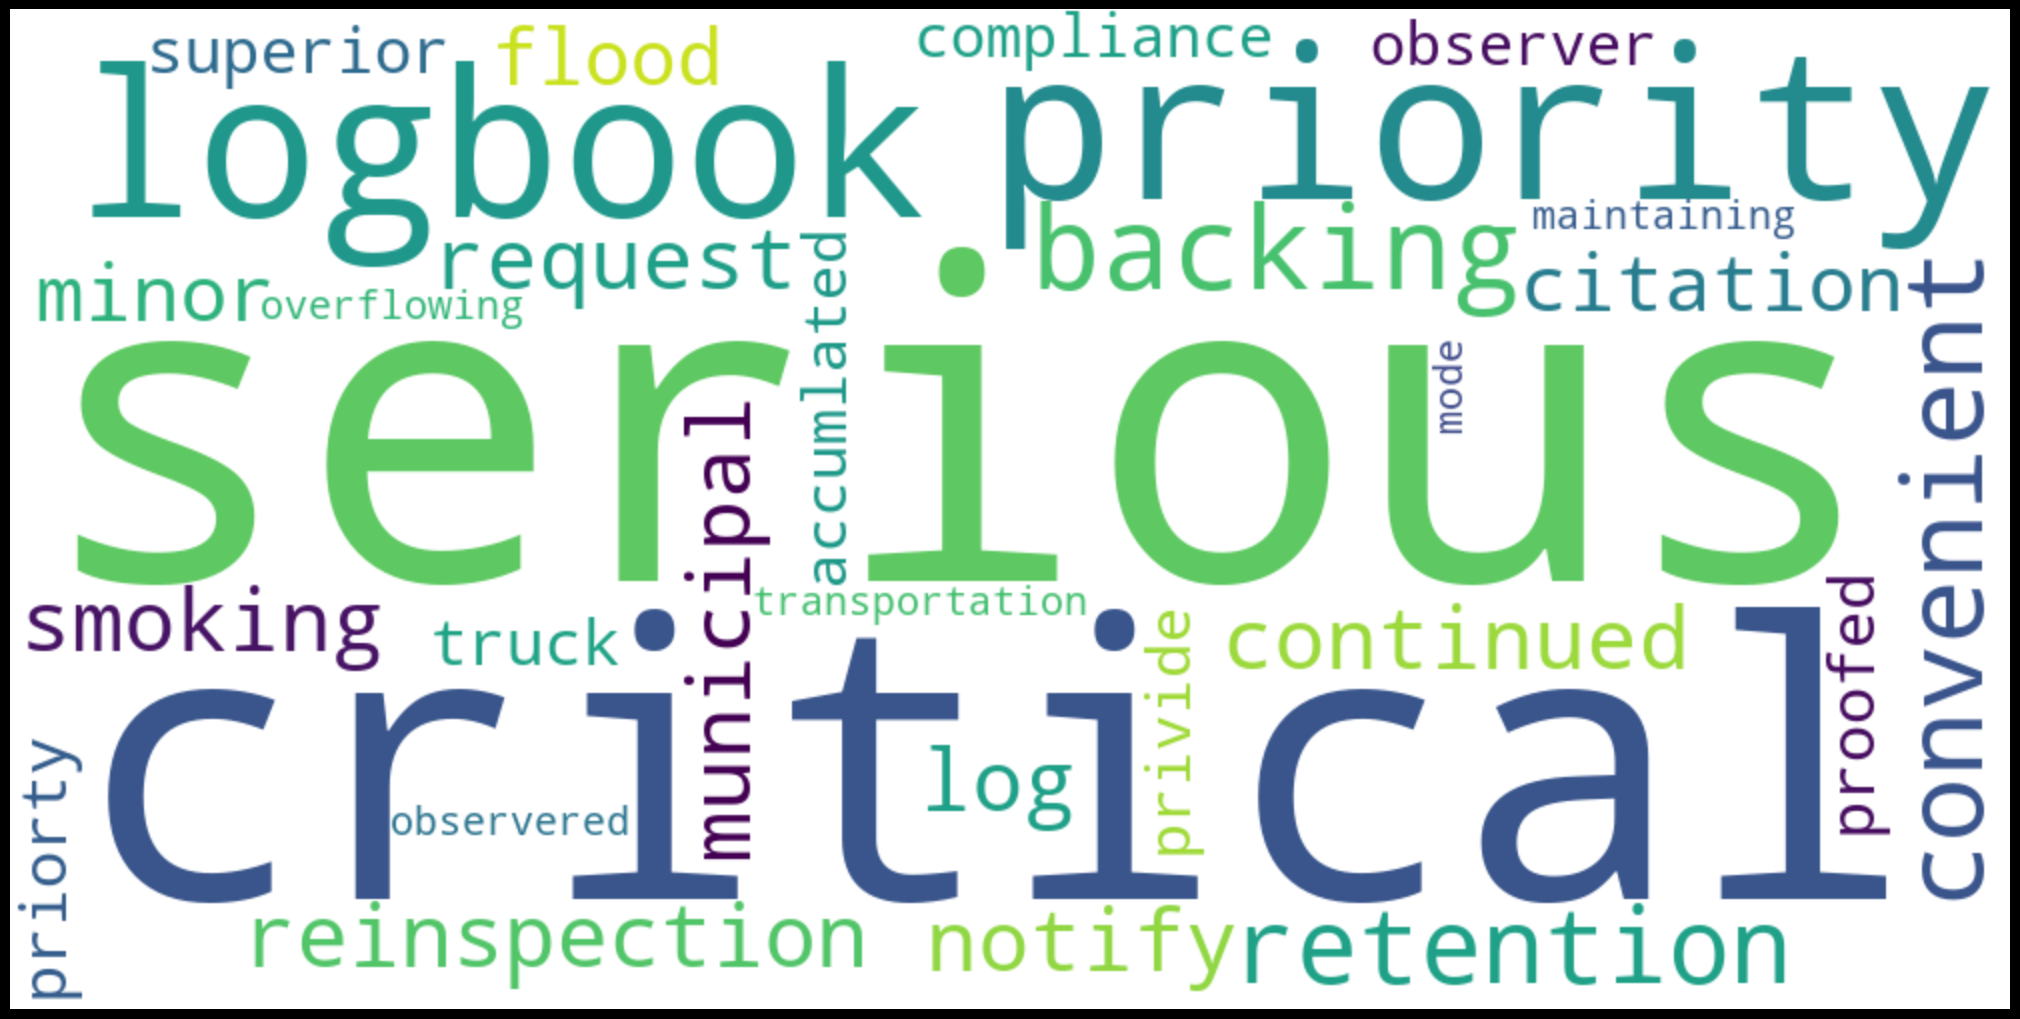

In [24]:
top_features_df = coefs_with_fns_df.copy()
top_features_df['coefficient'] = top_features_df['coefficient']*(-10)

data = dict(zip(top_features_df['feature'].tolist(), top_features_df['coefficient'].tolist()))


wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(data)

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

The above are the top features for Fail class

In [25]:
coefs_with_fns_df.sort_values(by='coefficient', ascending=False, inplace=True)
coefs_with_fns_df.head(10)

,feature,coefficient
2823,canvas,2.693284
14837,pickled,2.467552
7546,event,2.018889
7963,fax,2.007861
12938,miscellaneous,1.998962
17794,safety,1.905975
14200,otherwise,1.901806
4515,consume,1.826619
20292,tagged,1.823262
9173,grace,1.703283


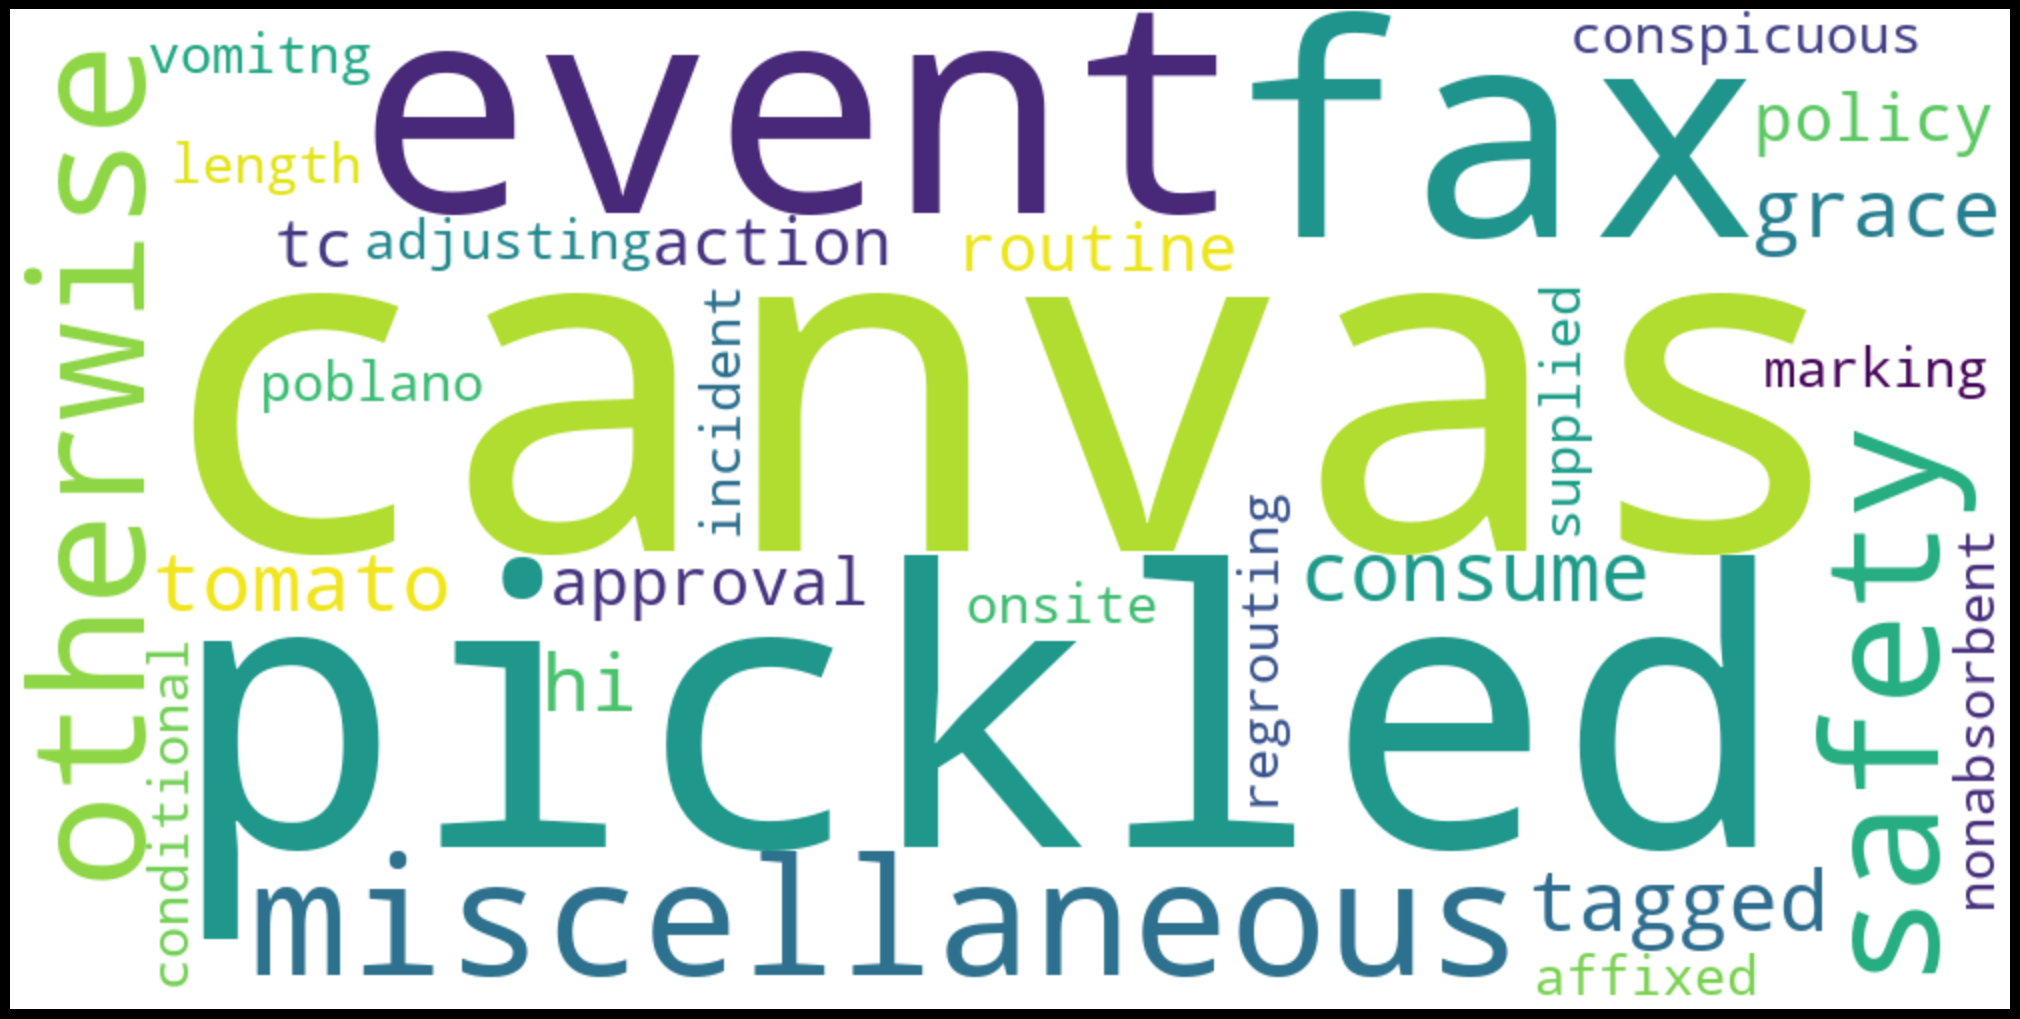

In [26]:
top_features_df = coefs_with_fns_df
top_features_df['coefficient'] = top_features_df['coefficient']*(10)

data = dict(zip(top_features_df['feature'].tolist(), top_features_df['coefficient'].tolist()))


wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(data)

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

These are the top features for the Pass class

Based on these words, they seem accurate in terms of food violations

### 3.2. TF-IDF

#### 3.2.1 Naive Bayes

In [27]:
# instantiate a TF-IDF vectorizer
vect = TfidfVectorizer()

# fit and transform training data with vectorizer
X_train_vect = vect.fit_transform(X_train)

# fit a Multinomial Naive Bayes model on the training data
nb = MultinomialNB()
nb.fit(X_train_vect, y_train)

# transform test data with vectorizer
X_test_vect = vect.transform(X_test)

# make predictions on test data
y_pred_tf_nb = nb.predict(X_test_vect)

# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_tf_nb) * 100:.1f}%")

Test Accuracy: 92.8%


In [28]:
print(classification_report(y_test, y_pred_tf_nb))

              precision    recall  f1-score   support

           0       0.93      0.83      0.88     11128
           1       0.93      0.97      0.95     24456

    accuracy                           0.93     35584
   macro avg       0.93      0.90      0.91     35584
weighted avg       0.93      0.93      0.93     35584



In [29]:
print(confusion_matrix(y_test, y_pred_tf_nb))

[[ 9233  1895]
 [  652 23804]]


Finding the best parameters for TF-IDF + Naive Bayes

In [30]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])
parameters = {
    'vectorizer__ngram_range': [(1, 2), (1, 3)]
}
# perform grid search to find the best hyperparameters
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# train a text classifier using the best hyperparameters
best_classifier_tf_nb = grid_search.best_estimator_
best_classifier_tf_nb.fit(X_train, y_train)

predictions_tf_nb = best_classifier_tf_nb.predict(X_test)
print(f"Test Accuracy: {metrics.accuracy_score(y_test, predictions_tf_nb) * 100:.1f}%")

Test Accuracy: 93.0%


In [31]:
print(classification_report(y_test, predictions_tf_nb))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88     11128
           1       0.92      0.98      0.95     24456

    accuracy                           0.93     35584
   macro avg       0.94      0.90      0.91     35584
weighted avg       0.93      0.93      0.93     35584



In [32]:
print(confusion_matrix(y_test, predictions_tf_nb))

[[ 9048  2080]
 [  421 24035]]


#### 3.2.2 Logistic Regression

In [33]:
# instantiate a TF-IDF vectorizer
vect = TfidfVectorizer()

# fit and transform training data with vectorizer
X_train_vect = vect.fit_transform(X_train)

# fit a Multinomial Naive Bayes model on the training data
logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train_vect, y_train)

# transform test data with vectorizer
X_test_vect = vect.transform(X_test)

# make predictions on test data
y_pred_tf_l = logreg.predict(X_test_vect)

# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_tf_l) * 100:.1f}%")

Test Accuracy: 97.4%


In [34]:
print(classification_report(y_test, y_pred_tf_l))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96     11128
           1       0.97      0.99      0.98     24456

    accuracy                           0.97     35584
   macro avg       0.98      0.96      0.97     35584
weighted avg       0.97      0.97      0.97     35584



In [35]:
print(confusion_matrix(y_test, y_pred_tf_l))

[[10394   734]
 [  181 24275]]


Finding the best parameters for TF-IDF + Logistic Regression

In [36]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=5000))
])
parameters = {
    'vect__ngram_range': [(1, 2), (1, 3)],
    'clf__C': [0.01, 0.1, 1.0],
}
# perform grid search to find the best hyperparameters
grid_search = GridSearchCV(pipeline, parameters, cv=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# train a text classifier using the best hyperparameters
best_classifier_tf_l = grid_search.best_estimator_
best_classifier_tf_l.fit(X_train, y_train)

predictions_tf_l = best_classifier_tf_l.predict(X_test)
print(f"Test Accuracy: {metrics.accuracy_score(y_test, predictions_tf_l) * 100:.1f}%")

Test Accuracy: 97.6%


In [37]:
print(classification_report(y_test, predictions_tf_l))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     11128
           1       0.97      0.99      0.98     24456

    accuracy                           0.98     35584
   macro avg       0.98      0.97      0.97     35584
weighted avg       0.98      0.98      0.98     35584



In [38]:
print(confusion_matrix(y_test, predictions_tf_l))

[[10426   702]
 [  164 24292]]


#### 3.2.3 Most Important Features

In [39]:
clf = logreg


feature_names = vect.get_feature_names_out()
coefs_with_fns = zip(feature_names, clf.coef_[0])

coefs_with_fns_df = pd.DataFrame(coefs_with_fns,
                    columns=['feature', 'coefficient'])

In [40]:
coefs_with_fns_df.sort_values(by='coefficient', ascending=True, inplace=True)
coefs_with_fns_df.head(10)

,feature,coefficient
18350,serious,-30.424527
15677,priority,-14.556144
3607,citation,-13.759476
5186,critical,-13.588558
6683,droppings,-11.641598
22329,violation,-11.134559
11046,issued,-9.303608
4678,control,-9.074904
8547,foundation,-8.524119
13163,mouse,-7.294323


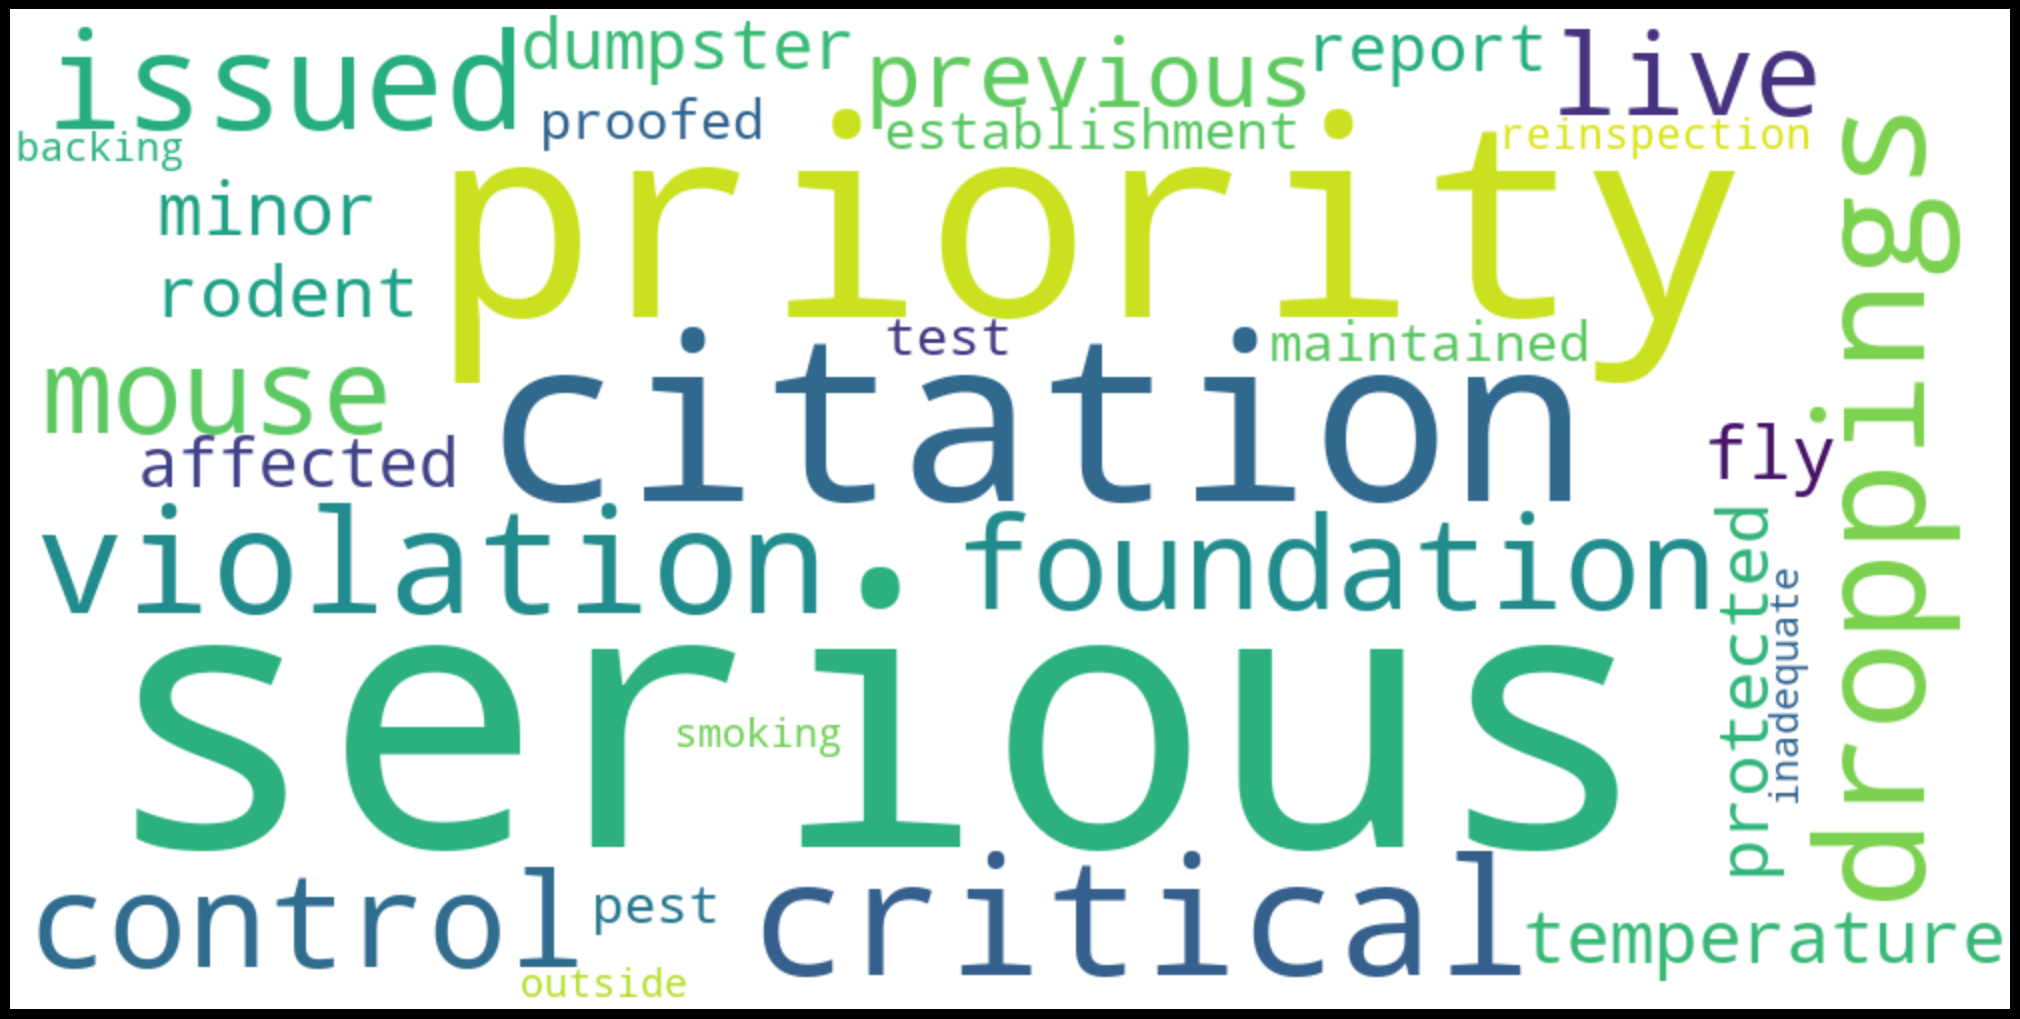

In [41]:
top_features_df = coefs_with_fns_df.copy()
top_features_df['coefficient'] = top_features_df['coefficient']*(-10)

data = dict(zip(top_features_df['feature'].tolist(), top_features_df['coefficient'].tolist()))


wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(data)

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

The above are the top features for Fail class

In [42]:
coefs_with_fns_df.sort_values(by='coefficient', ascending=False, inplace=True)
coefs_with_fns_df.head(10)

,feature,coefficient
598,allergen,3.442350
3981,code,3.107306
21247,training,2.836129
20783,thoroughly,2.351435
18753,signage,2.338711
15101,policy,2.306353
9564,handler,2.226989
11469,label,2.209461
20695,thermometer,2.124602
4485,conspicuous,2.083573


These are the top features for Pass class

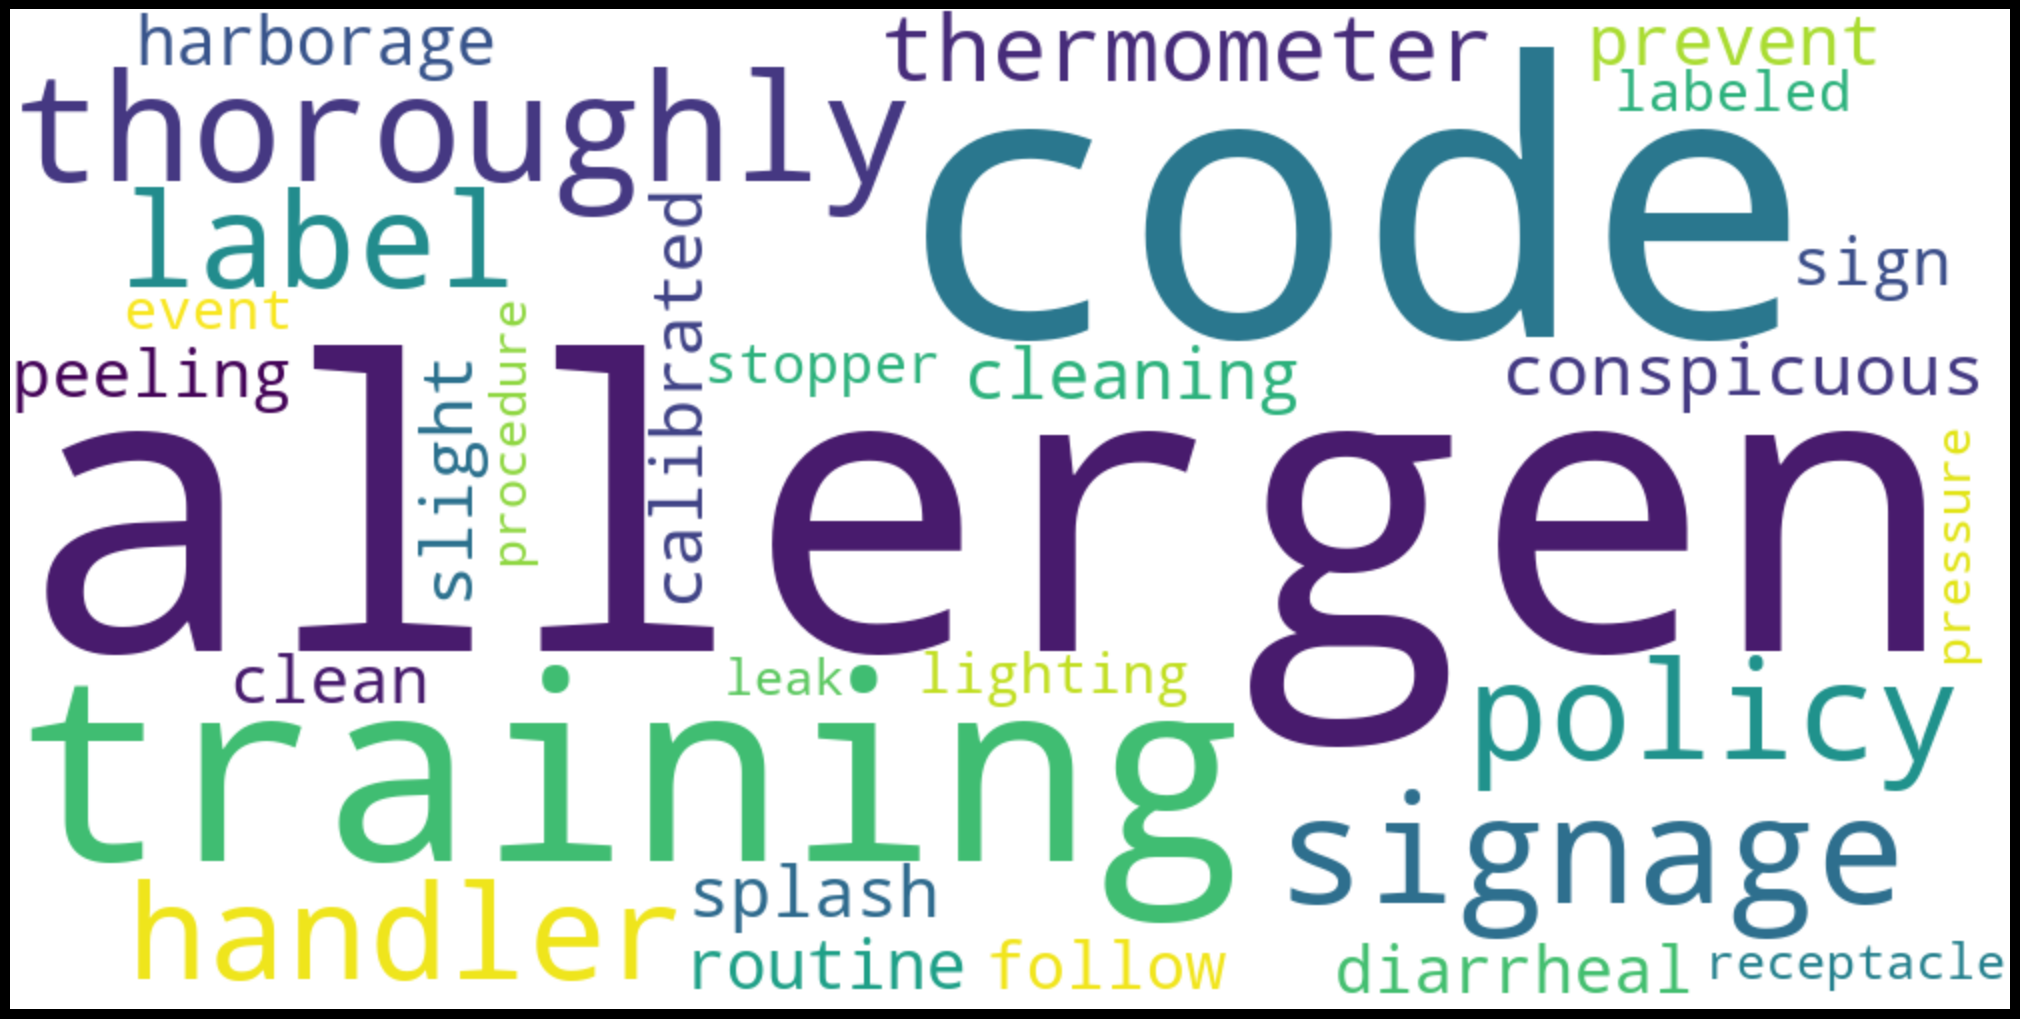

In [43]:
top_features_df = coefs_with_fns_df
top_features_df['coefficient'] = top_features_df['coefficient']*(10)

data = dict(zip(top_features_df['feature'].tolist(), top_features_df['coefficient'].tolist()))


wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(data)

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## 4. Conclusion

- I chose lemmatization as my text-preprocessor as in the previous assignments, lemmatization performed the best compared to others.
- I believe TF-IDF with Logistic Regression may be a more reliable model for food inspection violations compared to CountVectorizer with Logistic Regression, even though it may have slightly lower accuracy. This is because TF-IDF can more effectively weight terms based on their relevance to the target variable, resulting in more informative top features. In contrast, CountVectorizer may include terms that are not as relevant to the target variable, such as "backing" and "continued", which could reduce the effectiveness of the model.